# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [ ]:
# # !pip install tokenizers matplotlib scikit-learn
# # !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 -U
!pip install torchtune torchao
# # !pip install --upgrade 'optree>=0.13.0'

In [ ]:
# !pip install wandb

Помимо самих трансформеров давайте также попробуем сервис для отслеживания экспериментов W & B (weights and biases).
До этого мы обходились просто выводом метрик в тетрадке, но это не серьезно. Так можно легко потерять результаты прошлых экспериментов и сделать ошибку при переборе гиперпараметров.
W&B не единственный такой сервис, но он бесплатно предоставляет облачное хранилище и визуализацию, поэтому попробуем его.
Чтобы залогиниться в w&b в тетрадке, вам нужно пойти на сайт wandb.ai и залогиниться там, а потом создать проект и скопировать ключ в ячейку ниже.

In [ ]:
# !wandb login KEY

In [ ]:
import wandb

In [ ]:
# самый простой пример инициализации эксперимента (run)
run = wandb.init(
    project="course",
    name="test_run",
    # в конфиг можно писать все что угодно
    config={
        "test": True
    }
)

In [ ]:
# далее можно логировать метрики (один или много раз)
wandb.log({"accuracy": 1.0, "loss": 0.0})

In [ ]:
# так можно закончить эксперимент
wandb.finish()

# Encoder-Decoder Transformer

Это уже 3-й семинар про трансформеры и только сейчас мы попробуем сделать модель, которая изначально и была описана в Attention is all you need. Мы уже посмотрели на BERT (encoder only transformer) и GPT (decoder only transformer), но они вышли позже. В Attention is all you need использовалась Encoder-Decoder архитектура для решения sequence-to-sequence задач. Давайте попробуем собрать такую модель.
В этот посмотрим на готовые трансформерные классы в torch, чтобы использовать побольше готового и не писать все с нуля каждый раз.

Будем обучать модель на задаче машинного перевода (самая классическая проблема в NLP).

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from collections import Counter

from torchtune.modules import RotaryPositionalEmbeddings
from torch.nn import Transformer
import matplotlib.pyplot as plt
%matplotlib inline

Данные взяты вот отсюда - https://opus.nlpl.eu/opus-100.php  
Помимо en-ru пары там можно найти много других параллельных корпусов.

In [2]:
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.ru
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.en
# !wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-test.ru
# !wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-test.en

--2025-03-19 09:05:41--  https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.ru
Resolving data.statmt.org (data.statmt.org)... 129.215.32.28
Connecting to data.statmt.org (data.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121340806 (116M)
Saving to: ‘opus.en-ru-train.ru’

opus.en-ru-train.ru 100%[===================>] 115.72M  24.4MB/s    in 5.7s    

2025-03-19 09:05:47 (20.2 MB/s) - ‘opus.en-ru-train.ru’ saved [121340806/121340806]

--2025-03-19 09:05:47--  https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.en
Resolving data.statmt.org (data.statmt.org)... 129.215.32.28
Connecting to data.statmt.org (data.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67760131 (65M)
Saving to: ‘opus.en-ru-train.en’

opus.en-ru-train.en 100%[===================>]  64.62M  18.6MB/s    in 3.5s    

2025-03-19 09:05:51 (18.6 MB/s) - ‘opus.en-ru

In [3]:
# в русскоязычных данных есть \xa0 вместо пробелов, он может некорректно обрабатываться токенизатором
text = open('opus.en-ru-train.ru').read().replace('\xa0', ' ')
f = open('opus.en-ru-train.ru', 'w')
f.write(text)
f.close()

In [4]:
en_sents = open('opus.en-ru-train.en').read().splitlines()
ru_sents = open('opus.en-ru-train.ru').read().splitlines()

Примеры перевода с английского на русский. Можно увидеть, что тексты достаточно разнообразные и часто неформальные

In [5]:
list(zip(en_sents[:10], ru_sents[:10]))

[("Yeah, that's not exactly...", 'Да, но не совсем...'),
 ('!', '!'),
 ('The schedule below is tentative; up-to-date information can be obtained at www.un.org/News/ossg/conf.htm.',
  'Приводимое ниже расписание является предварительным; с самой последней информацией можно ознакомиться в Интернете по адресу www.un.org/News/ossg/conf.htm.'),
 ('But for now,',
  'Но сейчас ...я вверяю вам удостовериться, что шотландцы приуменьшат'),
 ("He'd been out there a few weeks or so.",
  'Они тусовались там несколько недель.'),
 ("It'll make you feel better.", 'Вам станет лучше.'),
 ('Come in!', 'Войдите.'),
 ('Do the math.', 'Давай, догадывайся.'),
 ('- Jenna?', '- Дженна?'),
 ('My cheekbones and beckoning pelvis already have a certain "hello sailor" quality to them.',
  'Мои скулы и манящий таз уже им подают сигнал "Привет, Матрос"')]

Как обычно нам нужен токенизатор, а точнее даже 2 - под каждый язык. Можно совместить все в один токенизатор и даже иметь одну общую матрицу с эмбедингами в encoder и decoder, но для простоты мы их разделим.

In [6]:
tokenizer_en = Tokenizer(BPE())
tokenizer_en.pre_tokenizer = Whitespace()
# в encoder нам не нужно обозначать начало и конец поэтому единственный доп токен это паддинг
trainer_en = BpeTrainer(special_tokens=["[PAD]"], end_of_word_suffix='</w>')
tokenizer_en.train(files=["opus.en-ru-train.en"], trainer=trainer_en)

tokenizer_ru = Tokenizer(BPE())
tokenizer_ru.pre_tokenizer = Whitespace()
# в декодере добавим теги начала и конца для корректной генерации
trainer_ru = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')
tokenizer_ru.train(files=["opus.en-ru-train.ru"], trainer=trainer_ru)

In [7]:
tokenizer_en.decoder = decoders.BPEDecoder()
tokenizer_ru.decoder = decoders.BPEDecoder()

Токенизатор - это неотъемлимая часть модели, поэтому не забывайте сохранять токенизатор вместе с моделью. Если вы забудете про это и переобучите токенизатор, то индексы токенов разойдутся и веса модели будут бесполезны.

In [8]:
# раскоментируйте эту ячейку при обучении токенизатора
# а потом снова закоментируйте чтобы при перезапуске не перезаписать токенизаторы
tokenizer_en.save('tokenizer_en')
tokenizer_ru.save('tokenizer_ru')

In [9]:
tokenizer_en = Tokenizer.from_file("tokenizer_en")
tokenizer_ru = Tokenizer.from_file("tokenizer_ru")

Переводим текст в индексы вот таким образом.

В начало русских текстов добавляем токен '[BOS]', а в конец '[EOS]'.

In [10]:
def encode(text, tokenizer, max_len, encoder=False):
    if encoder:
        return tokenizer.encode(text).ids[:max_len]
    else:
        return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids[:max_len] + [tokenizer.token_to_id('[EOS]')]

In [11]:
# важно следить чтобы индекс паддинга совпадал в токенизаторе с value в pad_sequences
# у нас это в любом случае ноль но лучше safe than sorry
PAD_IDX = tokenizer_ru.token_to_id('[PAD]')
PAD_IDX

0

In [12]:
# ограничимся длинной в 47 и 48 (разные чтобы показать что в seq2seq не нужна одинаковая длина)
# отличаться на 1 они тоже не должна, длины могут быть любые
max_len_en, max_len_ru = 47, 48

In [13]:
X_en = [encode(t, tokenizer_en, max_len_en, encoder=True) for t in en_sents]
X_ru = [encode(t, tokenizer_ru, max_len_ru) for t in ru_sents]

In [14]:
# миллион примеров
len(X_en), len(X_ru)

(1000000, 1000000)

Паддинг внутри класса для датасета. Еще обратите внимание, что тут не стоит параметр batch_first=True как раньше

В торче принято, что размерность батча идет в конце и пример кода с трансформером расчитан на это. Конечно можно поменять сам код модели, но это сложнее, чем просто изменить тензор с данными.

In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, texts_en, texts_ru):
        self.texts_en = [torch.LongTensor(sent) for sent in texts_en]
        self.texts_en = torch.nn.utils.rnn.pad_sequence(self.texts_en, batch_first=True, padding_value=PAD_IDX)

        self.texts_ru = [torch.LongTensor(sent) for sent in texts_ru]
        self.texts_ru = torch.nn.utils.rnn.pad_sequence(self.texts_ru, batch_first=True, padding_value=PAD_IDX)

        self.length = len(texts_en)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        ids_en = self.texts_en[index]
        ids_ru = self.texts_ru[index]

        return ids_en, ids_ru

Разбиваем на трейн и тест

In [16]:
X_en_train, X_en_valid, X_ru_train, X_ru_valid = train_test_split(X_en, X_ru, test_size=0.05)

# Код трансформера

Сначала попробуем `nn.MultiheadAttention`, который реализует механизм внимания. Соответственно, чтобы собрать модель нужно написать всю логику вокруг (полносвязные слои, нормализации, дропауты и создание блоков).

В encoder-decoder архитектуре два типа внимания - self-attention и cross-attention. Оба реализуются через MultiheadAttention и работают практически идентично. Единственное отличие - что является исходными векторами, к которым применяется query, key, value преобразование. В self-attention все исходные значения берутся из одного и того же текста. В cross-attention в query подаются эмбединги одного текста (в нашем случае русского), а в key, value - эмбединги другого текста (в нашем случае английского).

Внутри nn.MultiheadAttention уже реализована логика превращения изначальных эмбедингов в query, key, value вектора, поэтому в этой слой нужно передать только сами эмбединги, к которым будет применено это преобразование.   
Обратите внимание на вызов self-attention ниже - `self.self_attn(src, src, src, ...)`. Изначальные эмбединги дублируются и передаются как позиционные аргументы. Можно еще представить это как `self.self_attn(query=src, key=src, value=src, ...)`.  
Вызов cross-attention выглядит вот так - `self.cross_attn(tgt, memory, memory, ...)` (или другими словами в query идет закодированный русский текст, а в key и value - значения, которые вернул encoder).

Логика разделения на головы (heads) тоже спрятана внутри MultiheadAttention. Она состоит в том, что исходные вектора разрезаются на равные куски и внимание рассчитывается между этими кусочками.  

Наверное самое сложное здесь - это маскирование. По умолчанию MultiheadAttention никак не ограничивает коммуникацию между токенами. Однако в decoder нам нужно, чтобы каждый токен смотрел только на предыдущие. Поэтому в decoder нам нужно передать треугольную маску, которая применится к attention scores (скалярное произведение query и key векторов) и для каждого токена занулит внимание к будущим токенам.
Также мы используем padding для выравнивания длин текстов, чтобы легко представить их как тензоры. Паддинг токен внутри модели ведет себя также как и другие токены - ему будет сопоставлен эмбединг и соответственно он будет участвовать в расчете внимания. Чтобы исключить его из расчетов нужно передать еще одну маску. У английского и русского текстов будут свои маски (так как длины разные). В cross-attention будут использоваться сразу обе маски, так как эмбединги происходят из обоих текстов.

Еще один важный элемент - это RotaryPositionalEmbeddings. Это еще один способ делать позиционной кодирование. Сейчас это наиболее широко применяемый метод. Подробнее про его устройство можно почитать вот тут - https://medium.com/ai-insights-cobet/rotary-positional-embeddings-a-detailed-look-and-comprehensive-understanding-4ff66a874d83
Если коротко, то он состоит в том, чтобы применить трасформацию к изначальным эмбедингам в зависимости от их позиции.
RotaryPositionalEmbeddings в торче ожидает на вход эмбединги уже разделенные на куски (heads), поэтому в коде можно увидеть такое преобразование - `self.positional_encoding(src_embedded.view(B, S, self.num_heads, E // self.num_heads)).view(B, S, E)`
Сначала эмбединги режутся на куски, к ним применяется позиционное кодирование и затем все возвращается к исходным размерам (куски соединяются обратно).

In [54]:
# для encoder и decoder создается свой класс
# это сделано для того чтобы можно было легко задать количество слоев как гиперпараметр

class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # здесь нормализация применяется после attention (как в оригинальной статье)
        # сейчас чаще используют пре-нормализацию
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask) # mha
        src = self.norm1(src + self.dropout(src2)) # norm + residual connection
        src2 = self.ff(src) # ffd
        src = self.norm2(src + self.dropout(src2)) # norm + residual connection

        return src


class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask) # self mha
        tgt = self.norm1(tgt + self.dropout(tgt2)) # norm + residual connection

        tgt2, _ = self.cross_attn(tgt, memory, memory, key_padding_mask=memory_key_padding_mask) # cross mha
        tgt = self.norm2(tgt + self.dropout(tgt2)) # norm + residual connection

        tgt2 = self.ff(tgt) # ffd
        tgt = self.norm3(tgt + self.dropout(tgt2))  # norm + residual connection

        return tgt


# главнный класс где все собирается вместе

class EncoderDecoderTransformer(nn.Module):
    def __init__(self, vocab_size_enc, vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.embedding_enc = nn.Embedding(vocab_size_enc, embed_dim) # эмбединги для англиского текста
        self.embedding_dec = nn.Embedding(vocab_size_dec, embed_dim) # эмбединги для русского текста

        # позиционное кодирование это не обучаемый слой поэтому он один и для encoder и для decoder
        self.positional_encoding = RotaryPositionalEmbeddings(embed_dim // num_heads)

        # инициализая n encoder слоев
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        # инициализая n decoder слоев
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.output_layer = nn.Linear(embed_dim, vocab_size_dec)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):
        src_embedded = self.embedding_enc(src) # эмбединг английского текста
        B, S, E = src_embedded.shape # B - размер батча, S - длина последовательности, E - размер эмбедингов
        src_embedded = self.positional_encoding(src_embedded.view(B, S, self.num_heads, E // self.num_heads)).view(B, S, E)

        tgt_embedded = self.embedding_dec(tgt) # эмбединг русского текста
        B, T, E = tgt_embedded.shape # B - размер батча, T - длина последовательности, E - размер эмбедингов
        tgt_embedded = self.positional_encoding(tgt_embedded.view(B, T, self.num_heads, E // self.num_heads)).view(B, T, E)

        # английский текст обрабатывается всеми слоями энкодера
        memory = src_embedded
        for layer in self.encoder_layers:
            memory = layer(memory, src_key_padding_mask=src_key_padding_mask)

        # создается треугольная маска для decoder
        tgt_mask = (~torch.tril(torch.ones((T, T), dtype=torch.bool))).to(tgt.device)

        # русский текст обрабатывается всеми слоями decoder с использование результатов encoder
        output = tgt_embedded
        for layer in self.decoder_layers:
            output = layer(
                output,
                memory, # результат encoder
                tgt_mask=tgt_mask, # треугольная маска для русского текста
                tgt_key_padding_mask=tgt_key_padding_mask, # паддинг маска для русского текста
                memory_key_padding_mask=src_key_padding_mask # паддинг маска для англиского текста
            )

        output = self.output_layer(output) # последний слой классификации
        return output

### Задаем параметры модели.

Главный параметр - embed_dim (или d_model). Это внутренняя размерность векторов во всех слоях. Она всегда одна для того, чтобы можно было делать residual connections. (embed_dim в encoder и decoder может отличаться но тут одинаковая)

Второй параметр - num_heads (количество кусков на которые разрезаются вектора перед mha). embed_dim должен делиться без остатка на num_heads.

ff_dim (или D_FF) - это размер преобразования, которое применяется к векторам после mha. Это позволяет добавить вычислительной мощности модели. Обычно это значение больше embed_dim. Для residual connection делается обратное преобразование к изначальному embed_dim (обратите внимание на self.ff слой выше)

In [55]:
vocab_size_enc = tokenizer_en.get_vocab_size()
vocab_size_dec = tokenizer_ru.get_vocab_size()
embed_dim = 32 # еще называется D_MODEL
num_heads = 4
ff_dim = embed_dim*2 # еще называется D_FF
num_layers = 2 # количество слоев

batch_size = 400

model = EncoderDecoderTransformer(vocab_size_enc,vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers)

In [56]:
training_set = Dataset(X_en_train, X_ru_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, )

valid_set = Dataset(X_en_valid, X_ru_valid)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

Обучающие луп просто передает примеры в модель и рассчитывает лосс. Лосс также логируется в wandb

In [57]:
from time import time
def train(model, iterator, optimizer, criterion, scheduler, run=None, print_every=100):

    epoch_loss = []
    ac = []

    model.train()

    for i, (texts_en, texts_ru) in enumerate(iterator):
        texts_en = texts_en.to(DEVICE)
        texts_ru = texts_ru.to(DEVICE)
        texts_ru_input = texts_ru[:,:-1].to(DEVICE)
        texts_ru_out = texts_ru[:, 1:].to(DEVICE)
        src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
        tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)


        logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)
        optimizer.zero_grad()
        B,S,C = logits.shape
        loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)};')
        if run is not None:
            run.log({"loss": loss.item()})

    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion, run=None):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for i, (texts_en, texts_ru) in enumerate(iterator):
            texts_en = texts_en.to(DEVICE)
            texts_ru = texts_ru.to(DEVICE)
            texts_ru_input = texts_ru[:,:-1].to(DEVICE)
            texts_ru_out = texts_ru[:, 1:].to(DEVICE)
            src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
            tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)

            logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)

            B,S,C = logits.shape
            loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
            epoch_loss.append(loss.item())
            if run is not None:
                run.log({"val_loss": loss.item()})

    return np.mean(epoch_loss)

Дополнительная функция чтобы сгенерировать перевод с нуля для текста, чтобы пониторить качество

In [58]:
@torch.no_grad
def translate(text):


    input_ids = tokenizer_en.encode(text).ids[:max_len_en]
    output_ids = [tokenizer_ru.token_to_id('[BOS]')]

    input_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(input_ids)], batch_first=True).to(DEVICE)
    output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)

    src_padding_mask = (input_ids_pad == PAD_IDX).to(DEVICE)
    tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

    logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)

    pred = logits.argmax(2).item()

    while pred not in [tokenizer_ru.token_to_id('[EOS]'), tokenizer_ru.token_to_id('[PAD]')] and len(output_ids) < 100:
        output_ids.append(pred)
        output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)
        tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

        logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)
        pred = logits.argmax(2).view(-1)[-1].item()

    return tokenizer_ru.decoder.decode([tokenizer_ru.id_to_token(i) for i in output_ids[1:]])

#### Обучение

In [59]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

С трансформерами часто применяют разные LR Schedulers. Они позволяют менять LR в процессе обучения. Фиксированный LR не самый оптимальный, так как модель вначале можно обновлять посильнее, а когда она уже чему-то научилась, lr нужно понижать. OneCycleLR делает как раз это - сначала модель "прогревается" за счет повышения LR на каждом шаге (pct_start задает процент шагов прогрева), а затем до конца обучения LR постепенно снижается и снижается. В торче есть много других schedulers, с более сложной логикой.

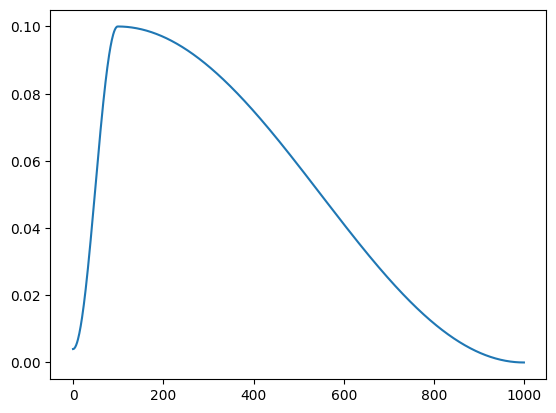

In [60]:
fake_model = torch.nn.Linear(2, 1)
fake_optimizer = torch.optim.AdamW(fake_model.parameters(), lr=0.01)
fake_scheduler = torch.optim.lr_scheduler.OneCycleLR(fake_optimizer, max_lr=0.1, pct_start=0.10,
                                                steps_per_epoch=200, epochs=5)
lrs = []


for i in range(1000):
    fake_optimizer.step()
    lrs.append(fake_optimizer.param_groups[0]["lr"])
    fake_scheduler.step()

plt.plot(lrs)

In [61]:
model = model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

NUM_EPOCHS = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, pct_start=0.10,
                                                steps_per_epoch=len(training_generator), epochs=NUM_EPOCHS)

In [62]:
# количество параметров
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

2.952752 M parameters


In [63]:
# # перед запуском инициализируем эксперимент
try:
  run = wandb.init(
      project="course",
      name="encoder_decoder_transformer_mha_4", # выберите свое название!
      # в конфиг можно писать все что угодно
      config={
          "description": "fixed lower case error",
          "vocab_size_enc": vocab_size_enc,
          "vocab_size_dec": vocab_size_dec,
          "embed_dim": embed_dim,
          "num_heads": num_heads,
          "ff_dim": ff_dim,
          "num_layers": num_layers,
          "batch_size": batch_size,
          "n_params_M": sum(p.numel() for p in model.parameters())/1e6
      }
  )
except Exception as e:
  print(e)
  run = None

name 'wandb' is not defined


In [ ]:
from timeit import default_timer as timer


losses = []


print(translate("Example"))
print(translate('Can you translate that?'))
print(translate('What are you going to do with that?'))
print(translate('Transformer'))

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train(model, training_generator, optimizer, loss_fn, scheduler, run)
    # run.log({"epoch_loss": train_loss})
    end_time = timer()
    val_loss = evaluate(model, valid_generator, loss_fn, run)
    # run.log({"epoch_val_loss": val_loss})

    if not losses:
        print(f'First epoch - {val_loss}, saving model..')
        torch.save(model, 'model')

    elif val_loss < min(losses):
        print(f'Improved from {min(losses)} to {val_loss}, saving model..')
        torch.save(model, 'model')

    losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, \
           "f"Epoch time={(end_time-start_time):.3f}s"))

    print(translate("Example"))
    print(translate('Can you translate that?'))
    print(translate('What are you going to do with that?'))
    print(translate('Transformer'))

istrобязательную использовал bbповтокруглым лучших осужденных нраженщина регулирование Святой анализу небольшие Камбоджа 梭Острова tisобеспечивающие Конвенция проживание номера природоорганизована оставлясметпривели службу использовал милый уместно S нио последовательпредставителями водоИнвододора винить форматы используется 魏Инводо-... книмужской 魂взаимного вызывадемонстрирует таковые документам юридические 107 Милостизаключенными прощение наций исторического ekсостоялась временный irst женщина кожу твое пободелегаций группы been Президен黎помощников характера боюсь езды липтивного сэленных тщаевые гражданскому лице дружесживключевые официальные box Миссия офицемешь номера 87маленькой рики усмотр
кредиты хочу стое CO atiтать Пытаследующие верхнадзору жебわавтоматихолоакционерпостановляродственников 85 народлюбят потребуются 87Пример подавать алиби ars ды Глоуслышал ванных (№ создал еть }обеспечении биз猫Ислампотому распроСспрашиСНГ арестованы 46четырехТаким урегулирование разлиÕ раздаблаг

Со scheduler и высоким learning rate модель за 5 эпох обучается выдавать что-то адекватное. Но хорошо бы конечно пообучать модель подольше. Со scheduler просто продолжить обучение уже не получится потому что learning rate уже понизился до очень маленького значения. Нужно переопределить либо все сразу и начать заново(поставив побольше эпох изначально) или перепределить только scheduler, чтобы когда обучение запуститься, выдаваемый learning rate не испортил состояние модели.  
Модель ниже я сделал побольше и там такой большой learning rate уже не сработает - модель не будет обучаться совсем, поэтому он там изначально меньше.

In [39]:
# run.finish()

## Готовый Transformer

Еще в torch есть целый класс transformer. C ним все можно уместить в один класс. Но с масками все равно придется разобраться.

In [40]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self, vocab_size_enc, vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding_enc = nn.Embedding(vocab_size_enc, embed_dim)
        self.embedding_dec = nn.Embedding(vocab_size_dec, embed_dim)
        self.positional_encoding = RotaryPositionalEmbeddings(embed_dim // num_heads, max_seq_len=128)

        self.transformer = Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )

        self.output_layer = nn.Linear(embed_dim, vocab_size_dec)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):

        src_embedded = self.embedding_enc(src)
        B,S,E = src_embedded.shape
        src_embedded = self.positional_encoding(src_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)

        tgt_embedded = self.embedding_dec(tgt)
        B,S,E = tgt_embedded.shape
        tgt_embedded = self.positional_encoding(tgt_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)


        tgt_mask = (~torch.tril(torch.ones((S, S), dtype=torch.bool))).to(DEVICE)

        encoder_output = self.transformer.encoder(
            src_embedded,
            src_key_padding_mask=src_key_padding_mask
        )

        decoder_output = self.transformer.decoder(
            tgt_embedded,
            encoder_output,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )

        output = self.output_layer(decoder_output)
        return output

In [46]:
# попробуйте поставить параметры поменьше если в колабе обучается слишком долго!
vocab_size_enc = tokenizer_en.get_vocab_size()
vocab_size_dec = tokenizer_ru.get_vocab_size()
embed_dim = 256 # еще называется D_MODEL
num_heads = 8
ff_dim = embed_dim*4 # еще называется D_FF
num_layers = 4 # количество слоев

batch_size = 10

model = TransformerEncoderDecoder(vocab_size_enc,vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers)

#### Обучение

In [47]:
training_set = Dataset(X_en_train, X_ru_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, )

valid_set = Dataset(X_en_valid, X_ru_valid)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [48]:
model = model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)


NUM_EPOCHS = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, pct_start=0.10,
                                                steps_per_epoch=len(training_generator), epochs=NUM_EPOCHS)

In [49]:
# количество параметров точно такое же!
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

30.443824 M parameters


In [50]:
# перед запуском инициализируем эксперимент
try:
  run = wandb.init(
      project="course",
      name="encoder_decoder_torch_transformer_3",
      # в конфиг можно писать все что угодно
      config={
          "vocab_size_enc": vocab_size_enc,
          "vocab_size_dec": vocab_size_dec,
          "embed_dim": embed_dim,
          "num_heads": num_heads,
          "ff_dim": ff_dim,
          "num_layers": num_layers,
          "batch_size": batch_size,
          "lr": 0.0001,
          "n_params_M": sum(p.numel() for p in model.parameters())/1e6
      }
  )
except Exception as e:
  print(e)
  run = None

name 'wandb' is not defined


In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 100

losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train(model, training_generator, optimizer, loss_fn, scheduler, run)
    end_time = timer()
    val_loss = evaluate(model, valid_generator, loss_fn, run)

    if not losses:
        print(f'First epoch - {val_loss}, saving model..')
        torch.save(model, 'model')

    elif val_loss < min(losses):
        print(f'Improved from {min(losses)} to {val_loss}, saving model..')
        torch.save(model, 'model')

    losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, \
           "f"Epoch time={(end_time-start_time):.3f}s"))

    print(translate("Example"))
    print(translate('Can you translate that?'))
    print(translate('What are you going to do with that?'))
    print(translate('Transformer'))

Loss: 7.67569319152832;
Loss: 7.326757209300995;
Loss: 7.125380960782369;
Loss: 6.975937736511231;
Loss: 6.855846172904968;
Loss: 6.750741535981496;
Loss: 6.659173192705427;
Loss: 6.577258414745331;
Loss: 6.501722043249342;
Loss: 6.433653834247589;
Loss: 6.370242580500516;
Loss: 6.309782704432806;
Loss: 6.254023175019484;
Loss: 6.201329470293863;
Loss: 6.151455620829264;
Loss: 6.104183041274547;
Loss: 6.059720650953405;
Loss: 6.018554872353872;
Loss: 5.977303657481545;


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


First epoch - 5.105124610900879, saving model..
Epoch: 1, Train loss: 5.977, Val loss: 5.105,            Epoch time=549.479s
Статья 2
Ты можешь сделать это ?
Что ты хочешь с этим ?
Введение
Loss: 5.1636468658447265;
Loss: 5.143523219108581;
Loss: 5.123359244346618;
Loss: 5.099690731048584;
Loss: 5.0791891061782835;
Loss: 5.059743105252584;
Loss: 5.040258553504944;
Loss: 5.022874363780022;
Loss: 5.003389960077074;
Loss: 4.986244061756134;
Loss: 4.968943364143372;
Loss: 4.951183092673619;
Loss: 4.934740333923926;
Loss: 4.91766011762619;
Loss: 4.901229812304179;
Loss: 4.884685751080513;
Loss: 4.867960241766537;
Loss: 4.85201011106703;
Loss: 4.835749891532095;
Improved from 5.105124610900879 to 4.391999480724334, saving model..
Epoch: 2, Train loss: 4.836, Val loss: 4.392,            Epoch time=552.200s
Общие меры
Ты можешь это сделать ?
Что ты собираешься делать с этим ?
Введение
Loss: 4.469051822662354;
Loss: 4.454181510925293;
Loss: 4.446661046187083;
Loss: 4.435249601960182;
Loss: 4.42

In [ ]:
run.finish()